In [18]:
#import library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
import numpy as np
import zipfile, os

In [19]:
# ==========================
# 1. Parameter & Path
# ==========================
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

base_dir = "D:/KULIAH UNDIP/SKRIPSI S NYA SANTUY/DATASET/Dataset New"
train_path = os.path.join(base_dir, "train")
test_path = os.path.join(base_dir, "test")


In [20]:
# ==========================
# 2. Data Augmentation
# ==========================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),  
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomFlip("vertical"),  
])



In [21]:
# ==========================
# 3. Load Dataset
# ==========================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
class_names = train_ds.class_names
num_classes = len(class_names)


Found 2647 files belonging to 3 classes.
Found 1137 files belonging to 3 classes.


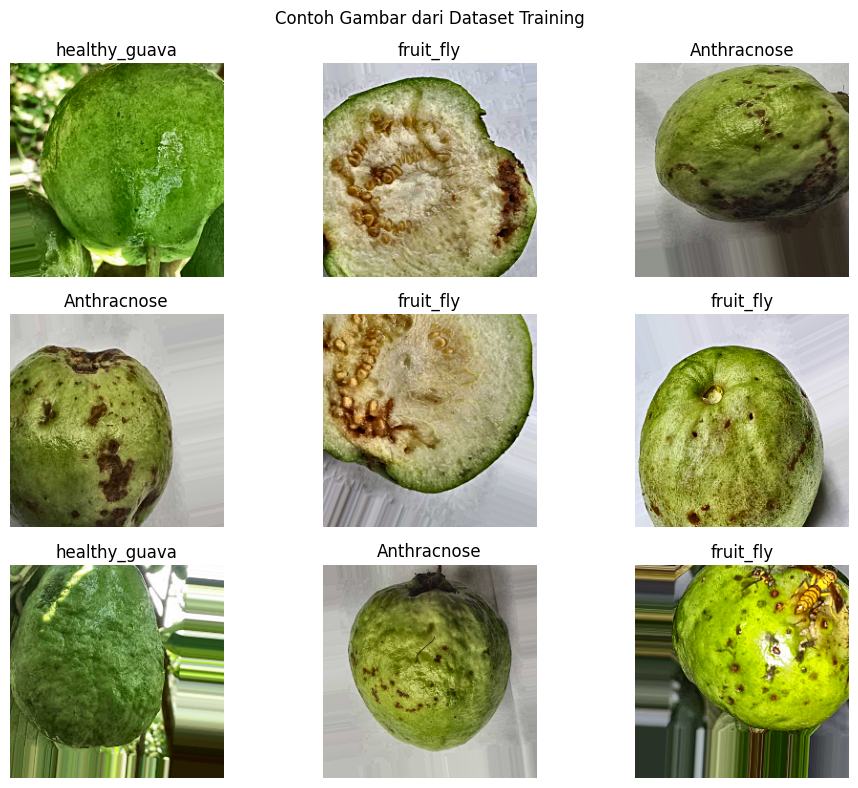

In [22]:
# Visualisasi beberapa gambar dari dataset training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.suptitle("Contoh Gambar dari Dataset Training")
plt.tight_layout()
plt.show()

In [23]:
# ==========================
# 4. CNN 
# ==========================
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Input(shape=IMAGE_SIZE + (3,)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [24]:
# ==========================
# 5. Class Weights (Optional)
# ==========================
# Flatten labels for class_weight
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

In [25]:
# ==========================
# 6. Compile Model
# ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# ==========================
# 7. Callbacks
# ==========================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]


In [27]:
# ==========================
# 8. Train
# ==========================
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy'),
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 337ms/step - accuracy: 0.4438 - loss: 1.3402 - val_accuracy: 0.6192 - val_loss: 0.9445
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 341ms/step - accuracy: 0.6582 - loss: 0.9455 - val_accuracy: 0.7792 - val_loss: 0.7491
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 338ms/step - accuracy: 0.7653 - loss: 0.7683 - val_accuracy: 0.8936 - val_loss: 0.5329
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 332ms/step - accuracy: 0.8252 - loss: 0.6734 - val_accuracy: 0.8848 - val_loss: 0.4972
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 330ms/step - accuracy: 0.8303 - loss: 0.6019 - val_accuracy: 0.8303 - val_loss: 0.5617
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 318ms/step - accuracy: 0.8467 - loss: 0.5635 - val_accuracy: 0.9112 - val_loss: 0.4161
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.8759 - loss: 0.5092 - val_accuracy: 0.8997 - val_loss: 0.4089
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.8949 - loss: 0.4763 - val_accu

In [28]:
# ==========================
# 9. Evaluate
# ==========================
loss, acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9674 - loss: 0.2921

Test Accuracy: 0.9499


In [29]:
# ==========================
# 10. Classification Report
# ==========================
from sklearn.metrics import classification_report


y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.96      0.97      0.96       464
    fruit_fly       0.96      0.95      0.95       394
healthy_guava       0.92      0.91      0.92       279

     accuracy                           0.95      1137
    macro avg       0.95      0.94      0.95      1137
 weighted avg       0.95      0.95      0.95      1137



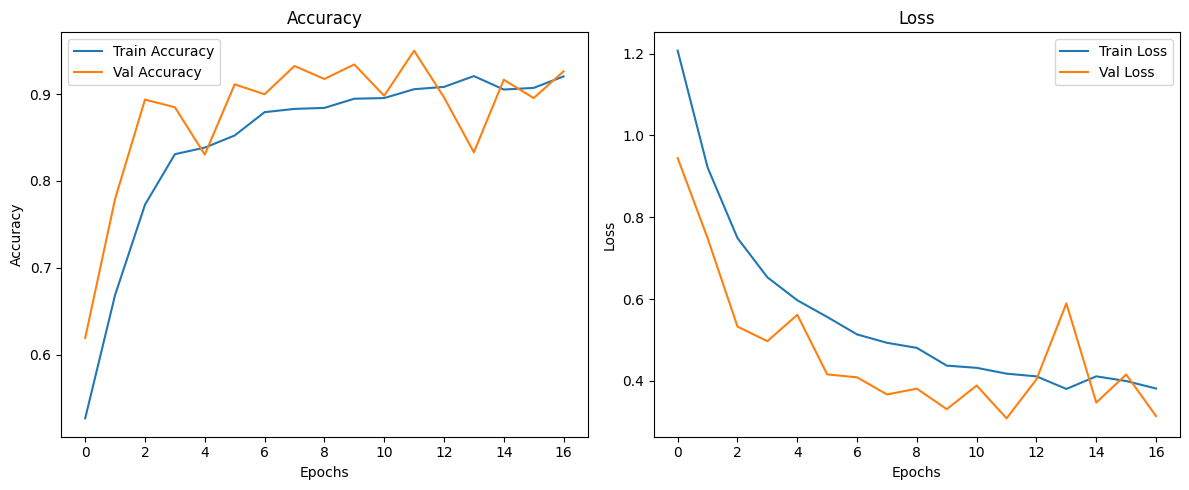

In [30]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

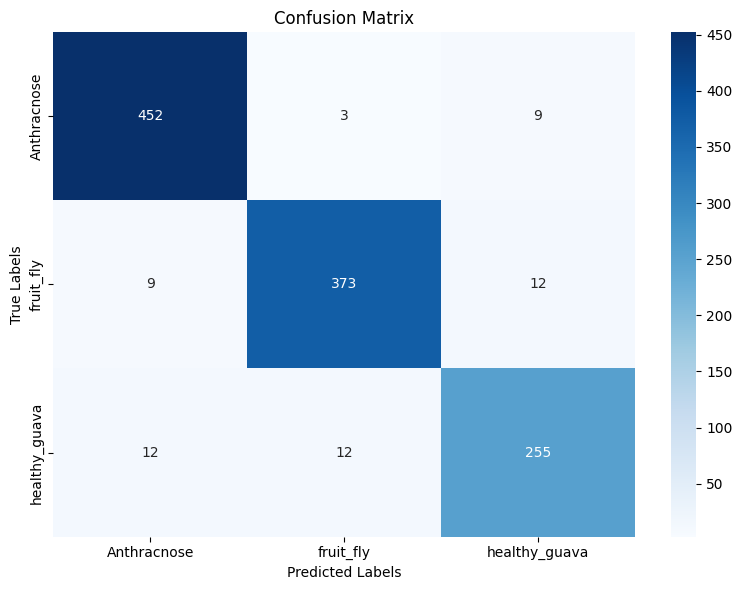

In [31]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


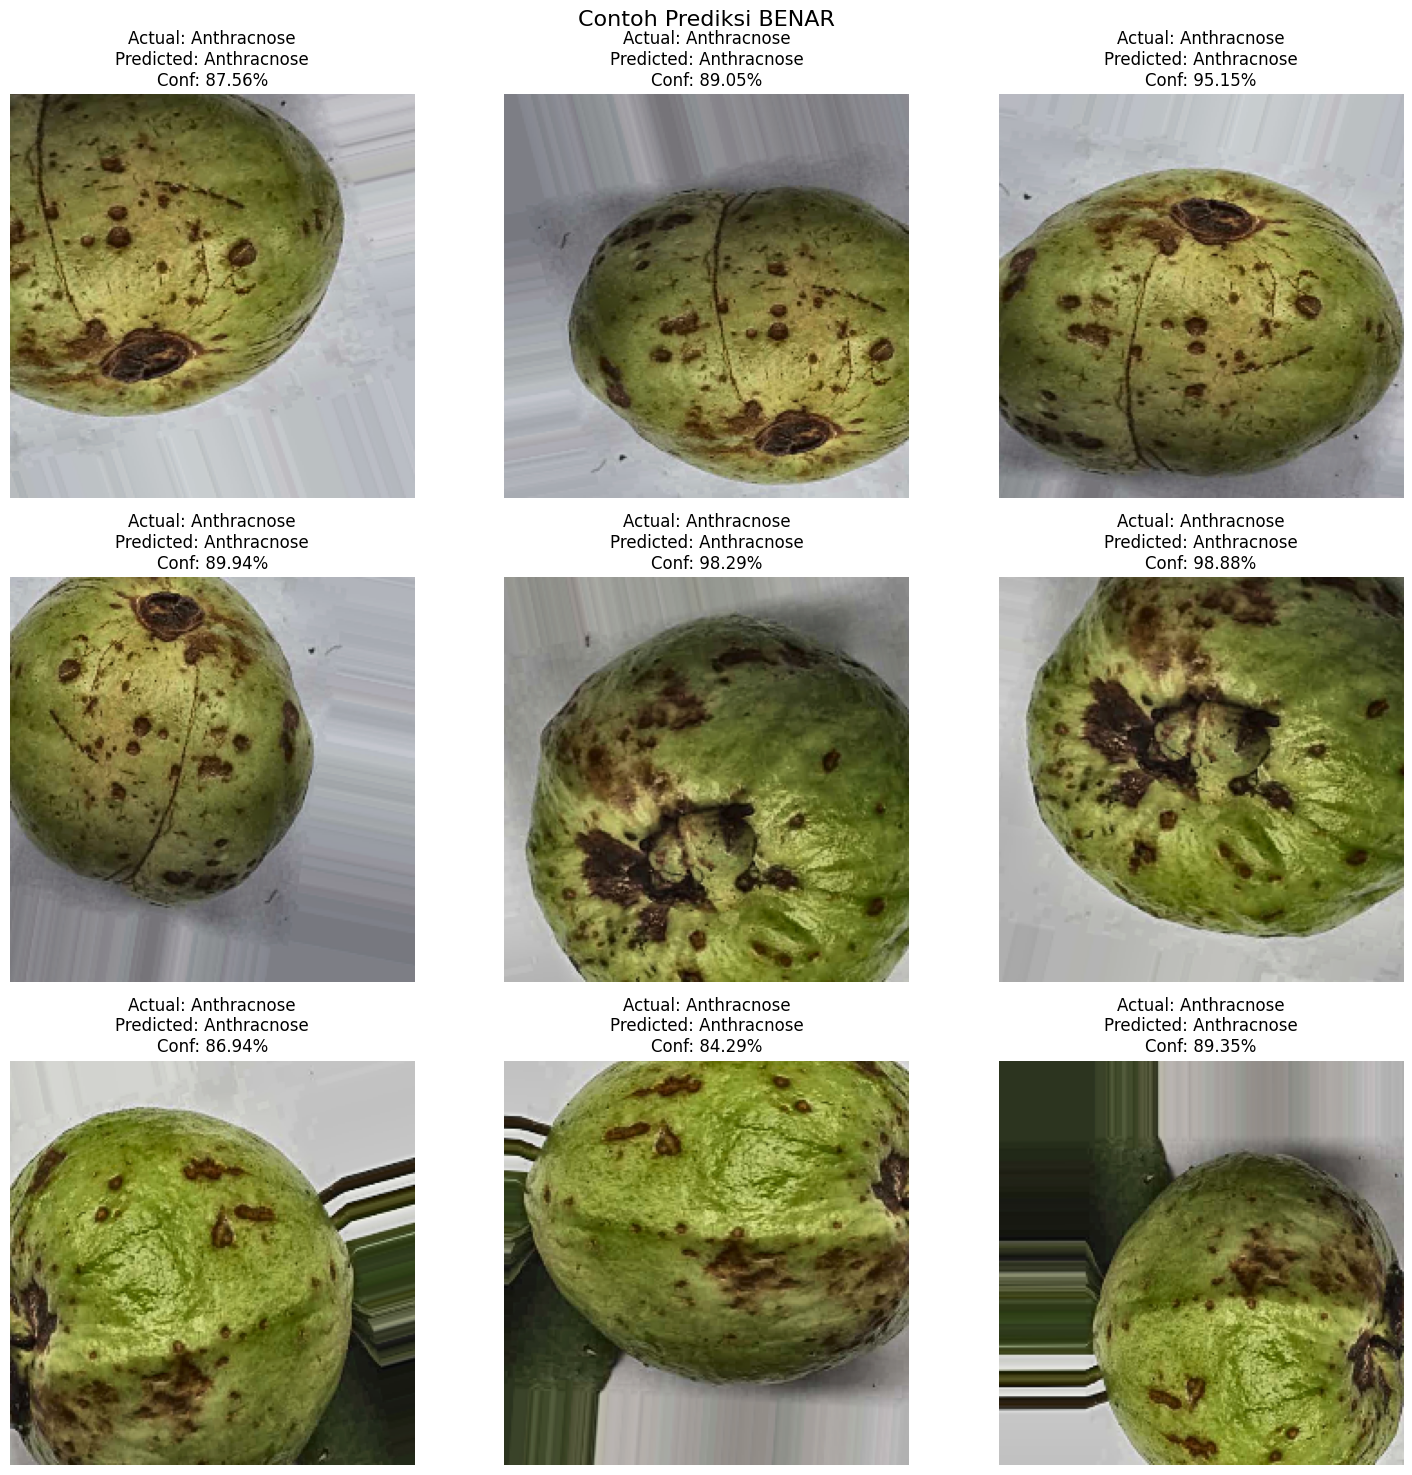

In [32]:
# Cell 16: Visualize Correct Predictions

plt.figure(figsize=(15, 15))
shown = 0

for images, labels in test_ds.unbatch().batch(1):
    predictions = model.predict(images)
    pred_class = np.argmax(predictions[0])
    true_class = np.argmax(labels[0])

    if pred_class == true_class:
        ax = plt.subplot(3, 3, shown + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConf: {np.max(predictions[0])*100:.2f}%")
        plt.axis("off")
        shown += 1
        if shown == 9:
            break

plt.suptitle("Contoh Prediksi BENAR", fontsize=16)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms

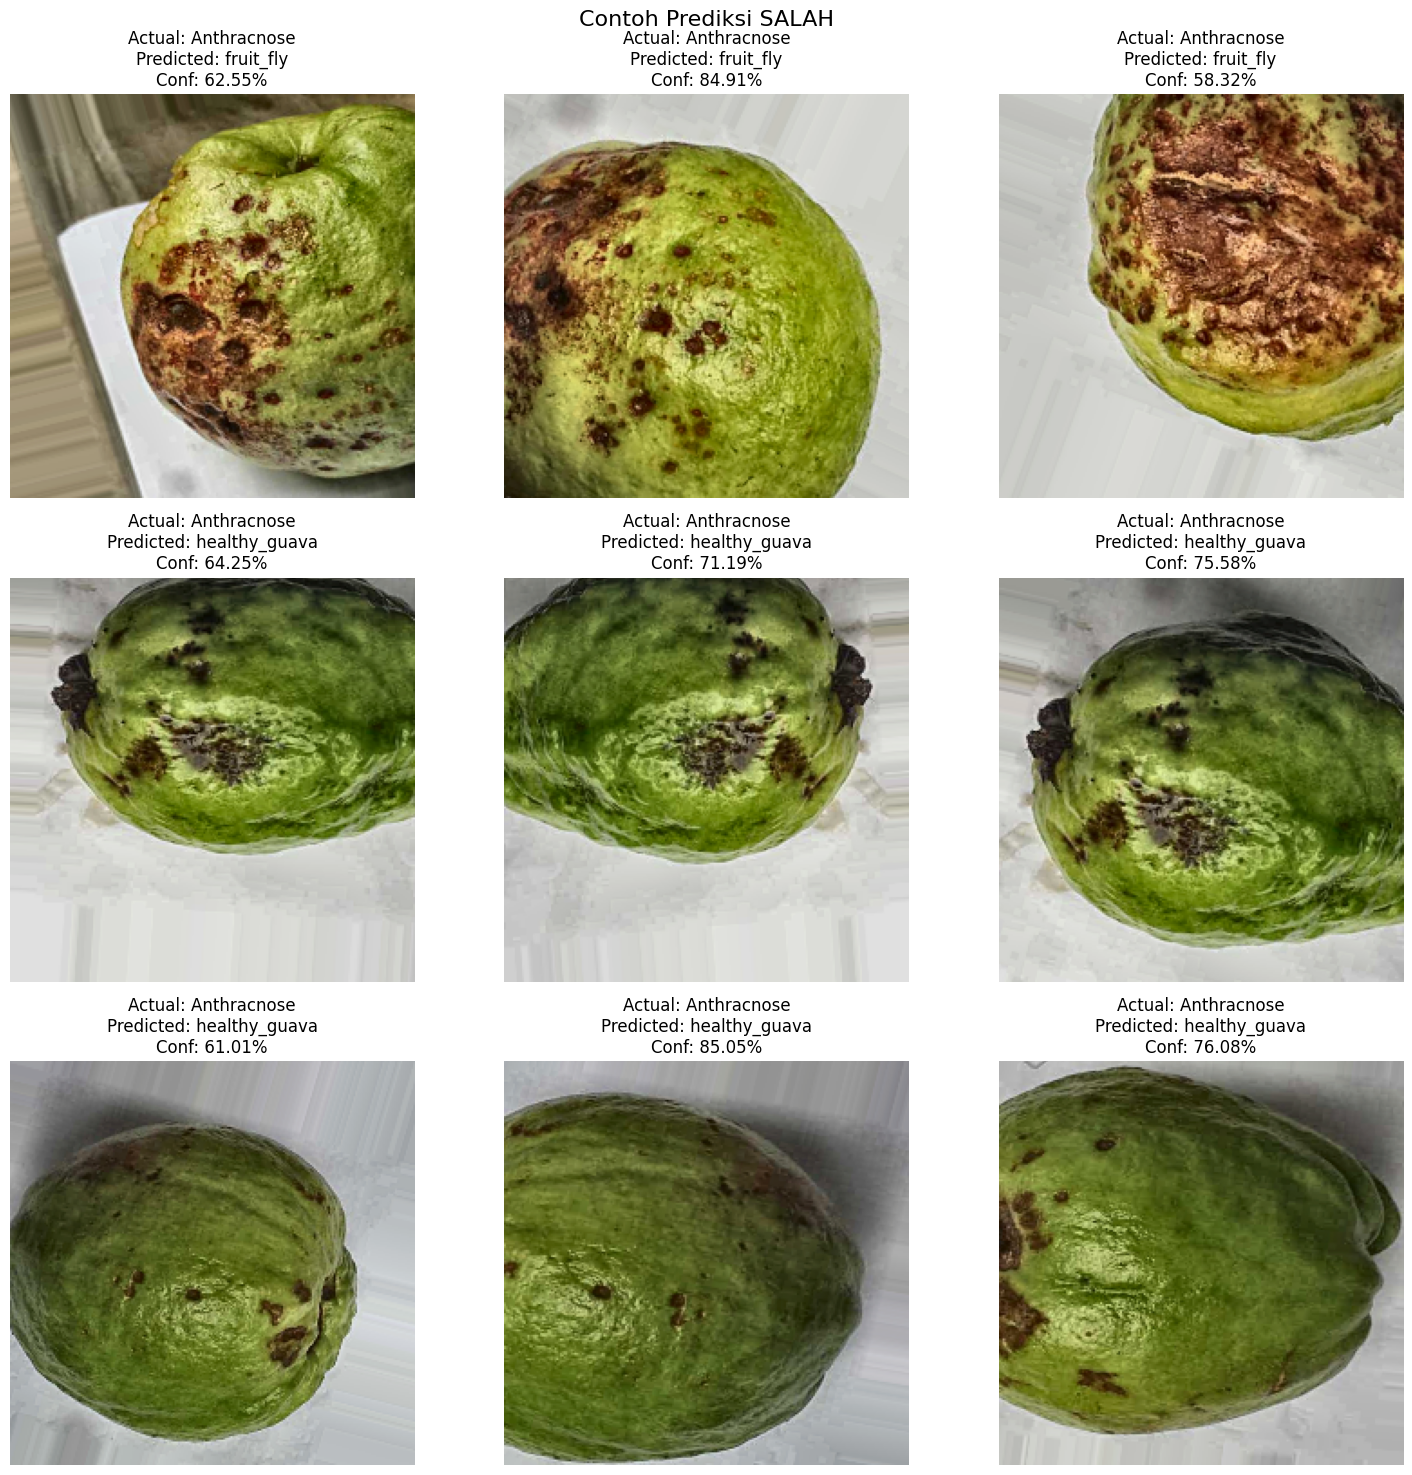

In [33]:
# Cell 17: Visualize Wrong Predictions

plt.figure(figsize=(15, 15))
shown = 0

for images, labels in test_ds.unbatch().batch(1):
    predictions = model.predict(images)
    pred_class = np.argmax(predictions[0])
    true_class = np.argmax(labels[0])

    if pred_class != true_class:
        ax = plt.subplot(3, 3, shown + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConf: {np.max(predictions[0])*100:.2f}%")
        plt.axis("off")
        shown += 1
        if shown == 9:
            break

plt.suptitle("Contoh Prediksi SALAH", fontsize=16)
plt.tight_layout()
plt.show()


In [34]:
# Save model terbaik
model.save("best_model.keras")

# Load model terbaik dari training
model = tf.keras.models.load_model("best_model.keras")

# Konversi ke TFLite (tanpa quantization untuk memastikan tidak rusak)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file
tflite_model_path = r'D:\KULIAH UNDIP\SKRIPSI S NYA SANTUY\python\GuavaDisease_CNN_Model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model exported to:", tflite_model_path)


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmp4tjngihw\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmp4tjngihw\assets


Saved artifact at 'C:\Users\lenovo\AppData\Local\Temp\tmp4tjngihw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2436064204496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064198928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064209296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064207376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064210640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064203536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064203920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064205264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064214672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2436064210448: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLit